# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [62]:
! pip install numpy
! pip install matplotlib
! pip install open-atmos-jupyter-utils

In [63]:
import numpy as np
from matplotlib import pyplot

In [64]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [65]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 1.5
t_max = 50

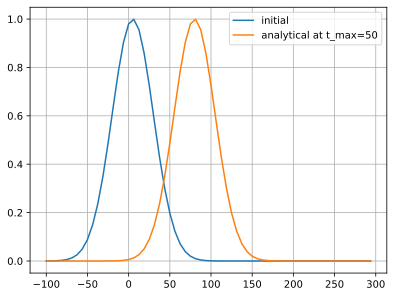

In [66]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [67]:
def F(L,R,C):
    return .5*(C+abs(C))*L + .5*(C-abs(C))*R

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [68]:
class One:
    def __radd__(self, o):
        return slice(o.start+1, o.stop+1)
    
    def __rsub__(self, o):
        return slice(o.start-1, o.stop-1)

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [69]:
one = One()
psi = psi_0(x)
i = slice(1, nx-2)
# nt = 50
nt = 16
dt = t_max/nt
C = u*dt/dx
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))

**7. comparing analytic and numerical solutions**

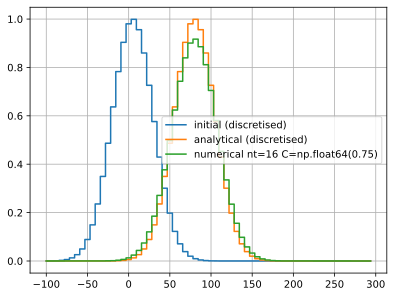

In [70]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()

# Convergence analysis of RMSE between numerical and analytic solution across different dx/dt with time to compute

In the following comparison, we're investigating how the RMSE changes over different values of dt/dx. By generating these graphs we're able to detect the point of diminishing returns for decreasing the value of dx/dt compared to how long it takes to compute the results.

The following test generates an advection upwind model with varying levels of precision. The nx/nt values (number of steps on our axis) changes at the same time to preserve the same value of **C**. 

Every calculation is measured in time for us to be able to see where the increase of precision converges with the time to calculate.

In [71]:
def RMSE(analytic, discrete):
    res = 0
    for i in range(0, len(discrete)):
        res += (analytic[i] - discrete[i]) ** 2
    
    res = np.sqrt(res/len(discrete))

    return res

In [105]:
from open_atmos_jupyter_utils import show_plot
import time

psi_0 = Psi_0()
one = One()
u = 1.5
t_max = 50

rmse = []
dxs = []
dts = []
solve_time = []

nt_nx_arr = np.logspace(4, 17, base=2, dtype=int)

for nt_nx in nt_nx_arr:
    start = time.time()
    x, dx = np.linspace(-100, 400, nt_nx, endpoint=False, retstep=True)
    psi = psi_0(x)
    i = slice(1, nt_nx-2)
    dt = t_max/nt_nx
    C = u * dt/dx
    for _ in range(nt_nx):
        psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))
    rmse.append(RMSE(psi_0(x-u*t_max), psi))
    dxs.append(dx)
    dts.append(dt)
    solve_time.append(time.time() - start)


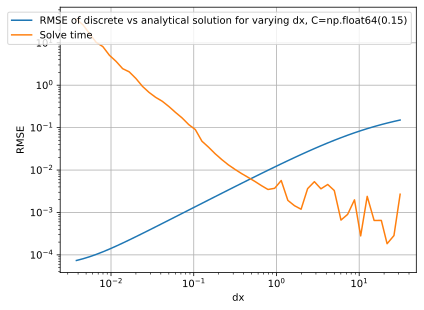

In [ ]:
pyplot.plot(dxs, rmse, label=f"RMSE of discrete vs analytical solution for varying dx, {C=}")
pyplot.plot(dxs, solve_time, label=f"Solve time")

pyplot.yscale("log")
pyplot.xscale("log")
pyplot.xlabel("dx")
pyplot.ylabel("RMSE")
pyplot.legend()
pyplot.grid()
show_plot()

## Conclusions
Looking at the generated results, we can see where the solve time converges with the RMSE curve. At around **dx=0.4** we will achieve the optimal precision for this model, where *C=0.15*